In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np



# Load INS data
ins_data = pandas.read_csv('csv/2-vectornav-ins.csv')
ins_data = ins_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
ins_data['time'] = pandas.to_datetime(ins_data['time'])
ins_data['time'] = (ins_data['time'] - ins_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
ins_data = ins_data.set_index('time')

# Load GPS Fix (raw) data
fix_data = pandas.read_csv('csv/2-vectornav-fix.csv')
fix_data = fix_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
fix_data['time'] = pandas.to_datetime(fix_data['time'])
fix_data['time'] = (fix_data['time'] - fix_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
fix_data = fix_data.set_index('time')



# Load IMU Data
imu_data = pandas.read_csv('csv/2-vectornav-imu.csv') 
imu_data = imu_data.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
imu_data['time'] = pandas.to_datetime(imu_data['time'])
imu_data['time'] = (imu_data['time'] - imu_data['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
imu_data = imu_data.set_index('time')


# Load Pacmod Speed Data
# pacmod parsed_txt/vehicle_speed is gets corrupt rows, so we will use as_tx/vehicle_speed
pacmod_speed = pandas.read_csv('csv/2-pacmod-as_tx-vehicle_speed.csv')
pacmod_speed['time'] = pandas.to_datetime(pacmod_speed['time'])
pacmod_speed['time'] = (pacmod_speed['time'] - pacmod_speed['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
# Additionally, there is an factor offset between parsed_txt/vehicle_speed and as_tx/vehicle_speed for whatever reason
# Use 2.237
pacmod_speed['.data'] = pacmod_speed['.data']*2.237
pacmod_speed = pacmod_speed.set_index('time')

# Load Pacmod Steer Data
pacmod_steer = pandas.read_csv('csv/2-pacmod-parsed_tx-steer_rpt.csv')
pacmod_steer = pacmod_steer.drop(columns=['.header.stamp.secs','.header.stamp.nsecs'])
pacmod_steer['time'] = pandas.to_datetime(pacmod_steer['time'])
pacmod_steer['time'] = (pacmod_steer['time'] - pacmod_steer['time'][0]).astype('timedelta64[ns]').astype('int64')*1e-9
pacmod_steer = pacmod_steer.set_index('time')


# Add some basic calculations to dataframes ...

# Mangitude of speed
ins_data['.mag_speed'] = (ins_data['.NedVel.y']**2 + ins_data['.NedVel.x']**2)**(1/2)

# ENU Frame - subtract 90 from yaw
yaw = (90 - ins_data['.RPY.z']) * np.pi/180
ins_x_vel = ins_data['.NedVel.y'] 
ins_y_vel = ins_data['.NedVel.x'] 

# Local velocity at IMU location
ins_data['.LocalVel.x'] = np.multiply(ins_x_vel,np.cos(yaw)) + np.multiply(ins_y_vel,np.sin(yaw))
ins_data['.LocalVel.y'] = -np.multiply(ins_x_vel,np.sin(yaw)) + np.multiply(ins_y_vel,np.cos(yaw))
del yaw, ins_x_vel, ins_y_vel # clear unused variables
ins_data.head()

,.header.seq,.header.frame_id,.Time,.Week,.Status,.RPY.x,.RPY.y,.RPY.z,.LLA.x,.LLA.y,...,.YawUncertainty,.PitchUncertainty,.RollUncertainty,.PosUncertainty,.VelUncertainty,.SyncInTime,.SyncInCount,.mag_speed,.LocalVel.x,.LocalVel.y
time,,,,,,,,,,,,,,,,,,,,,
0.000000,44214,vectornav,1.266945e+09,2094,13062,1.554333,-0.617273,-174.452194,30.673873,-96.371919,...,0.543483,0.073371,0.072572,0.804987,0.122528,1.582908e+09,0,1.717633,1.717432,0.026323
0.019984,44215,vectornav,1.266945e+09,2094,13062,1.538289,-0.616196,-174.448029,30.673872,-96.371919,...,0.543557,0.073451,0.072654,0.806461,0.122830,1.582908e+09,0,1.711808,1.711658,0.022698
0.040056,44216,vectornav,1.266945e+09,2094,39686,1.521309,-0.616636,-174.442230,30.673872,-96.371919,...,0.543613,0.073512,0.072715,0.807569,0.123054,1.582908e+09,0,1.705647,1.705536,0.019435
0.059926,44217,vectornav,1.266945e+09,2094,39686,1.508114,-0.616459,-174.438095,30.673872,-96.371919,...,0.542033,0.072769,0.072138,0.801763,0.120434,1.582908e+09,0,1.683194,1.682922,0.030239
0.080064,44218,vectornav,1.266945e+09,2094,774,1.489034,-0.614845,-174.433899,30.673872,-96.371919,...,0.542107,0.072850,0.072220,0.803201,0.120737,1.582908e+09,0,1.678317,1.678062,0.029247


In [3]:
predicted_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading

for steering,time in zip(pacmod_steer['.manual_input'],pacmod_steer.index):
    V = pacmod_speed.iloc[pacmod_speed.index.get_loc(time,method='nearest')]['.data']
    prediction = predicted_yaw[-1] - (V/3.4)*np.tan(steering/20.0)*0.033 # updated equation. 
    prediction = (prediction + np.pi) % (2* np.pi) - np.pi # Wrap to pi
    predicted_yaw.append(prediction)



In [4]:
imu_yaw = [ins_data['.RPY.z'][0]* np.pi/180] # Initialize first heading value to INS heading
for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    y0 = imu_data['.Gyro.z'].iloc[i]
    integration = imu_yaw[-1] + (y0)*(t1-t0)
    integration = (integration + np.pi) % (2* np.pi) - np.pi # Wrap to pi
    imu_yaw.append(integration)


## Integrating Yaw

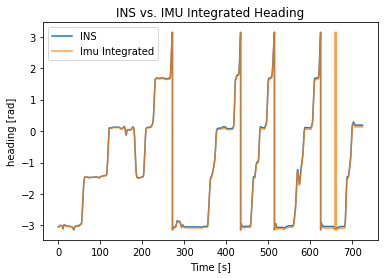

In [5]:
plt.figure()
plt.plot(ins_data.index.values,ins_data['.RPY.z'] * np.pi/180,label='INS') # plot yaw
plt.plot(imu_data.index,imu_yaw,label='Imu Integrated',alpha=0.75)
plt.xlabel('Time [s]')
plt.ylabel('heading [rad]')
plt.title('INS vs. IMU Integrated Heading');
plt.legend()
plt.show();

Integrated yaw looks pretty good actually. Gyro data is probably less noisy than acceleration data. 

## Integrating Acceleration for Velocity

In [50]:
# Perform integration, Initialize to ins_data[0]
imu_vel_x = np.asarray([ins_data['.NedVel.x'].iloc[0]])
imu_vel_y = np.asarray([ins_data['.NedVel.y'].iloc[0]])

for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    v_x0 = imu_data['.Accel.x'].iloc[i]
    v_y0 = imu_data['.Accel.y'].iloc[i]
    vel_x = imu_vel_x[-1] + ( ((v_x0)*(t1-t0)))
    vel_y = imu_vel_y[-1] + ( ((v_y0)*(t1-t0))) 
    imu_vel_x = np.append(imu_vel_x,vel_x)
    imu_vel_y = np.append(imu_vel_y,vel_y)

imu_vel = (imu_vel_x**2 + imu_vel_y**2)**(1/2)


Text(0.5, 1.0, 'Comparison of IMU integrated vs. INS velocity')

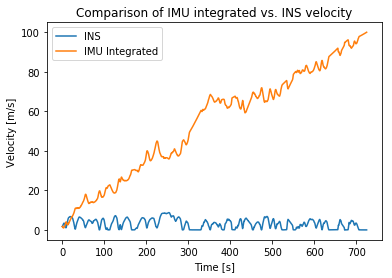

In [7]:
# Plot INS vs Imu Integrated velocity
plt.plot(ins_data.index,ins_data['.mag_speed'],label='INS')
plt.plot(imu_data.index,imu_vel,label="IMU Integrated")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.title('Comparison of IMU integrated vs. INS velocity')

### Where does this drift come from?

Let's observe some acceleration data when the velocity of the golfcart is zero (observed when the magnitude of the GPS speed is < 0.01 m/s)

In [51]:
v_is_zero = ins_data['.mag_speed'] < 1e-2
v_is_zero = ins_data[v_is_zero]['.mag_speed'] >= 0.0
v_is_zero = v_is_zero.index[v_is_zero]

imu_when_zeroV = pandas.DataFrame(columns=imu_data.columns)
for t in v_is_zero:
    imu = imu_data.iloc[imu_data.index.get_loc(t,method='nearest')]
    imu_when_zeroV = imu_when_zeroV.append(imu)
imu_when_zeroV.describe()

,.gps_time,.Mag.x,.Mag.y,.Mag.z,.Accel.x,.Accel.y,.Accel.z,.Gyro.x,.Gyro.y,.Gyro.z,.Temp,.Pressure
count,5.160000e+02,516.0,516.0,516.0,516.000000,516.000000,516.000000,516.000000,516.000000,5.160000e+02,516.0,516.0
mean,1.266946e+09,0.0,0.0,0.0,-0.122366,-0.020010,-9.770340,0.000046,-0.000037,-3.011717e-05,0.0,0.0
std,2.321865e+02,0.0,0.0,0.0,0.069663,0.315439,0.038663,0.001406,0.000913,8.262218e-04,0.0,0.0
min,1.266945e+09,0.0,0.0,0.0,-0.610216,-0.585047,-9.997847,-0.013105,-0.003440,-2.801860e-03,0.0,0.0
25%,1.266945e+09,0.0,0.0,0.0,-0.179675,-0.280792,-9.787780,-0.000642,-0.000589,-5.237618e-04,0.0,0.0
50%,1.266945e+09,0.0,0.0,0.0,-0.095944,0.139621,-9.772434,0.000081,-0.000052,3.431924e-07,0.0,0.0
75%,1.266946e+09,0.0,0.0,0.0,-0.077670,0.275701,-9.755797,0.000734,0.000497,4.258445e-04,0.0,0.0
max,1.266946e+09,0.0,0.0,0.0,0.279345,0.320220,-9.210734,0.005587,0.008886,4.991824e-03,0.0,0.0


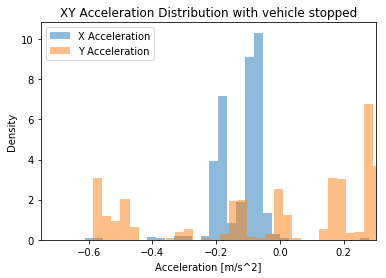

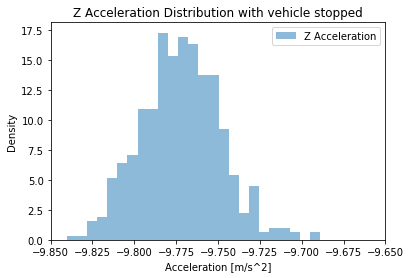

In [55]:
plt.figure()
plt.hist(imu_when_zeroV['.Accel.x'],bins=32,alpha=0.5,label="X Acceleration",density=True)
plt.hist(imu_when_zeroV['.Accel.y'],bins=32,alpha=0.5,label="Y Acceleration",density=True)
plt.xlim([-0.75,0.3])
plt.xlabel('Acceleration [m/s^2]')
plt.ylabel('Density')
plt.title('XY Acceleration Distribution with vehicle stopped')
plt.legend()
plt.figure()

plt.hist(imu_when_zeroV['.Accel.z'],bins=130,alpha=0.5,density=True,label="Z Acceleration")
plt.xlim([-9.85,-9.65])
plt.xlabel('Acceleration [m/s^2]')
plt.ylabel('Density')
plt.title('Z Acceleration Distribution with vehicle stopped')
plt.legend();

In [62]:
# Code accelerations by stop
imu_when_zeroV['group'] = None
c_time = imu_when_zeroV.index[0]
group = 0
for t in imu_when_zeroV.index:
    if np.abs(c_time - t) > 10: # Seperation time in seconds. Tune according to dataset
        group += 1
        c_time = t
    imu_when_zeroV.at[t,'group'] = group
    #print(t,group)
    #print(imu_when_zeroV)

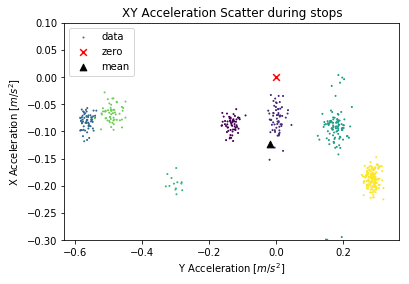

In [63]:
plt.title('XY Acceleration Scatter during stops')
plt.scatter(imu_when_zeroV['.Accel.y'],imu_when_zeroV['.Accel.x'],s=1,c=imu_when_zeroV['group'],label='data')
plt.scatter(0.0,0.0,s=45,color='red',label='zero',marker='x')
plt.scatter(imu_when_zeroV['.Accel.y'].mean(),imu_when_zeroV['.Accel.x'].mean(),s=45,marker='^',color='k',label='mean')
plt.ylim([-0.3,0.1])
plt.xlabel('Y Acceleration [$m/s^2$]')
plt.ylabel('X Acceleration [$m/s^2$]');
plt.legend()

## Subtracting out the bias, and re-integrating

In [67]:
bx = imu_when_zeroV['.Accel.x'].mean()
by = imu_when_zeroV['.Accel.y'].mean()

# Perform integration, Initialize to ins_data[0]
imu_vel_x = np.asarray([ins_data['.NedVel.x'].iloc[0]])
imu_vel_y = np.asarray([ins_data['.NedVel.y'].iloc[0]])

for i in range(imu_data.index.size - 1):
    t0 = imu_data.index[i]
    t1 = imu_data.index[i+1]
    v_x0 = imu_data['.Accel.x'].iloc[i]  - bx
    v_y0 = imu_data['.Accel.y'].iloc[i]  - by
    vel_x = imu_vel_x[-1] + ( ((v_x0)*(t1-t0)))
    vel_y = imu_vel_y[-1] + ( ((v_y0)*(t1-t0))) 
    imu_vel_x = np.append(imu_vel_x,vel_x)
    imu_vel_y = np.append(imu_vel_y,vel_y)

imu_vel = (imu_vel_x**2 + imu_vel_y**2)**(1/2)

Text(0.5, 1.0, 'Comparison of IMU integrated vs. INS velocity')

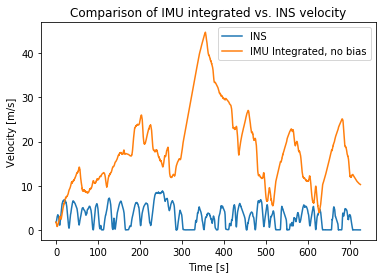

In [69]:
# Plot INS vs Imu Integrated velocity
plt.plot(ins_data.index,ins_data['.mag_speed'],label='INS')
plt.plot(imu_data.index,imu_vel,label="IMU Integrated, no bias")
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.title('Comparison of IMU integrated vs. INS velocity')